# Cassava Classification 

In [1]:
#code used from https://www.kaggle.com/code/pestipeti/cassava-pytorch-starter-train
import os
import numpy as np
import pandas as pd

import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import shap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings  
warnings.filterwarnings('ignore')

In [2]:
DIR_INPUT = './cassava-leaf-disease-classification/'
DEBUG = False

SEED = 42
N_FOLDS = 2 if DEBUG else 5
N_EPOCHS = 2 if DEBUG else 10
BATCH_SIZE = 128
SIZE = 256

In [3]:
sns.set(rc={'figure.figsize':(24,12)})

In [4]:
df = pd.read_csv('./cassava-leaf-disease-classification/train.csv')
#df['image_id'] = df['image_id'].apply(lambda x: f'../input/cassava-leaf-disease-classification/train_images/{x}')

numeric_to_class_name = {0:"Cassava Bacterial Blight (CBB)",
                         1:"Cassava Brown Streak Disease (CBSD)",
                         2:"Cassava Green Mottle (CGM)",
                         3:"Cassava Mosaic Disease (CMD)",
                         4:"Healthy"}

df['label'].replace(numeric_to_class_name, inplace=True)

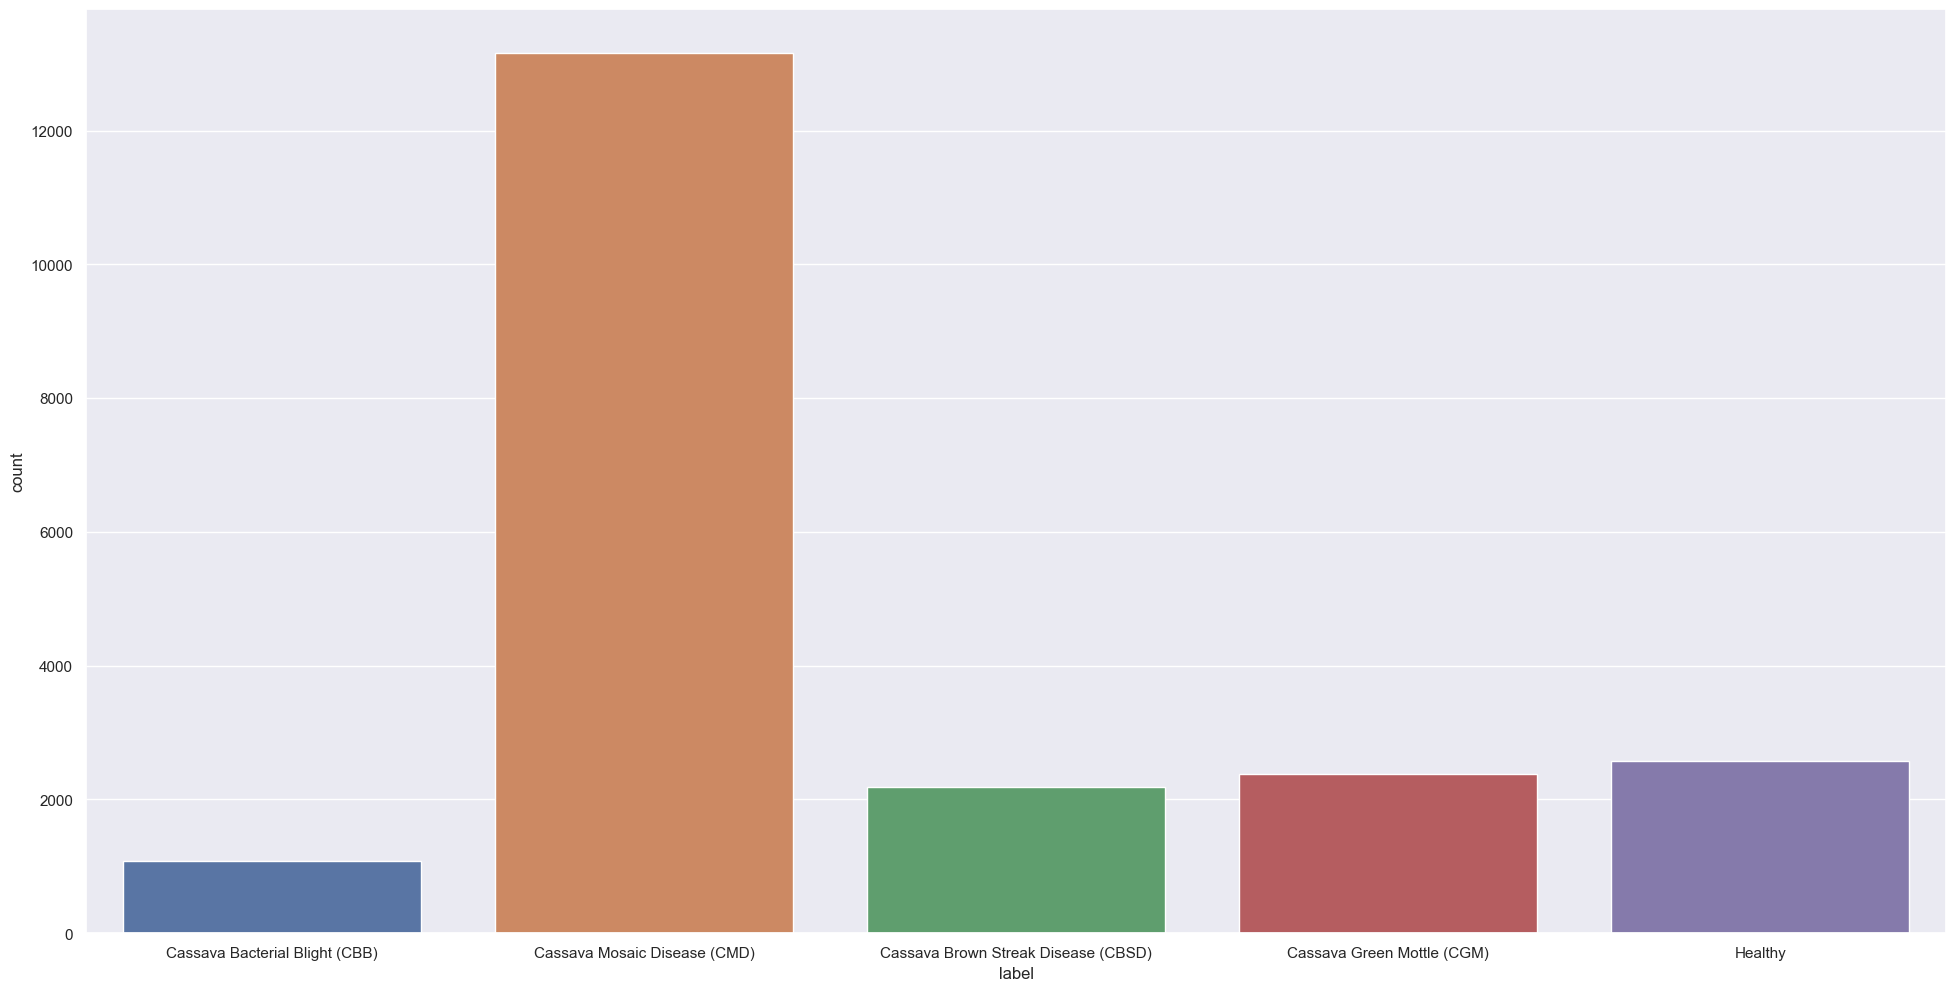

In [5]:
sns.countplot(data=df,x="label");

In [6]:
class CassavaDataset(Dataset):
    
    def __init__(self, df, dataset='train', transforms=None):
    
        self.df = df
        self.transforms=transforms
        self.dataset=dataset
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        image_src = f'{DIR_INPUT}/{self.dataset}_images/{self.df.loc[idx, "image_id"]}'
        # print(image_src)
        image = cv2.imread(image_src, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # label = self.df.loc[idx, 'label']
        labels = self.df.loc[idx, ['cls0', 'cls1', 'cls2', 'cls3', 'cls4']].values
        labels = torch.from_numpy(labels.astype(np.int8))
        labels = labels.unsqueeze(-1)
        
        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image, labels

In [7]:
class CassavaModel(nn.Module):
    
    def __init__(self, num_classes=5):
        super().__init__()
        
        self.backbone = torchvision.models.resnet18(pretrained=True)
        
        in_features = self.backbone.fc.in_features

        self.logit = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        batch_size, C, H, W = x.shape
        
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        x = F.dropout(x, 0.25, self.training)

        x = self.logit(x)

        return x

In [8]:
transforms_train = A.Compose([
    A.RandomResizedCrop(height=SIZE, width=SIZE, p=1.0),
    A.Flip(),
    A.ShiftScaleRotate(rotate_limit=1.0, p=0.8),

    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

transforms_valid = A.Compose([
    A.Resize(height=SIZE, width=SIZE, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0),
])

In [9]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df[['cls0', 'cls1', 'cls2', 'cls3', 'cls4']] = train_labels = pd.get_dummies(train_df.iloc[:, 1])

# For debugging.
if DEBUG:
    train_df = train_df.sample(n=100)
    train_df.reset_index(drop=True, inplace=True)

train_labels = train_df.iloc[:, 1].values

train_df.head()

,image_id,label,cls0,cls1,cls2,cls3,cls4
0,1000015157.jpg,0,1,0,0,0,0
1,1000201771.jpg,3,0,0,0,1,0
2,100042118.jpg,1,0,1,0,0,0
3,1000723321.jpg,1,0,1,0,0,0
4,1000812911.jpg,3,0,0,0,1,0


In [10]:
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
oof_preds = np.zeros((train_df.shape[0],))

In [11]:
class DenseCrossEntropy(nn.Module):

    def __init__(self):
        super(DenseCrossEntropy, self).__init__()
        
        
    def forward(self, logits, labels):
        logits = logits.float()
        labels = labels.float()
        
        logprobs = F.log_softmax(logits, dim=-1)
        
        loss = -labels * logprobs
        loss = loss.sum(-1)

        return loss.mean()

In [12]:
def train_one_fold(i_fold, model, criterion, optimizer, dataloader_train, dataloader_valid):
    
    train_fold_results = []

    for epoch in range(N_EPOCHS):

        # print('  Epoch {}/{}'.format(epoch + 1, N_EPOCHS))
        # print('  ' + ('-' * 20))
        os.system(f'echo \"  Epoch {epoch}\"')

        model.train()
        tr_loss = 0

        for step, batch in enumerate(dataloader_train):

            images = batch[0]
            labels = batch[1]

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)
            
            outputs = model(images)
            
            loss = criterion(outputs, labels.squeeze(-1))                
            loss.backward()

            tr_loss += loss.item()

            optimizer.step()
            optimizer.zero_grad()

        # Validate
        model.eval()
        val_loss = 0
        val_preds = None
        val_labels = None

        for step, batch in enumerate(dataloader_valid):

            images = batch[0]
            labels = batch[1]

            if val_labels is None:
                val_labels = labels.clone().squeeze(-1)
            else:
                val_labels = torch.cat((val_labels, labels.squeeze(-1)), dim=0)

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            with torch.no_grad():
                outputs = model(images)

                loss = criterion(outputs, labels.squeeze(-1))
                val_loss += loss.item()

                preds = torch.softmax(outputs, dim=1).data.cpu()

                if val_preds is None:
                    val_preds = preds
                else:
                    val_preds = torch.cat((val_preds, preds), dim=0)
        
        val_preds = torch.argmax(val_preds, dim=1)

        train_fold_results.append({
            'fold': i_fold,
            'epoch': epoch,
            'train_loss': tr_loss / len(dataloader_train),
            'valid_loss': val_loss / len(dataloader_valid),
            'valid_score': accuracy_score(torch.argmax(val_labels, dim=1), val_preds)
        })

    return val_preds, train_fold_results

In [13]:
submissions = None
train_results = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_labels)):
    print("Fold {}/{}".format(i_fold + 1, N_FOLDS))

    valid = train_df.iloc[valid_idx]
    valid.reset_index(drop=True, inplace=True)

    train = train_df.iloc[train_idx]
    train.reset_index(drop=True, inplace=True)    

    dataset_train = CassavaDataset(df=train, dataset='train', transforms=transforms_train)
    dataset_valid = CassavaDataset(df=valid, dataset='train', transforms=transforms_valid)

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE,  shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE,  shuffle=False)

    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')

    model = CassavaModel(num_classes=5)
    model.to(device)

    criterion = DenseCrossEntropy()
    plist = [{'params': model.parameters(), 'lr': 5e-5}]
    optimizer = optim.Adam(plist, lr=5e-5)
    
    val_preds, train_fold_results = train_one_fold(i_fold, model, criterion, optimizer, dataloader_train, dataloader_valid)
    oof_preds[valid_idx] = val_preds.numpy()
    
    train_results = train_results + train_fold_results
    
    torch.save({
        'fold': i_fold,
        'lr': optimizer.state_dict()["param_groups"][0]['lr'],
        'model_state_dict': model.cpu().state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        # 'scheduler_state_dict'
        # 'scaler_state_dict'
    }, f"model_state_fold_{i_fold}.pth")

print("{}-Folds CV score: {:.4f}".format(N_FOLDS, accuracy_score(train_labels, oof_preds)))

# Show train history

In [14]:
# train_results = pd.DataFrame(train_results)
# train_results.head(10)

In [15]:
fig = make_subplots(rows=2, cols=1)

colors = [
    ('#d32f2f', '#ef5350'),
    ('#303f9f', '#5c6bc0'),
    ('#00796b', '#26a69a'),
    ('#fbc02d', '#ffeb3b'),
    ('#5d4037', '#8d6e63'),
]

for i in range(N_FOLDS):
    data = train_results[train_results['fold'] == i]

    fig.add_trace(go.Scatter(x=data['epoch'].values,
                             y=data['train_loss'].values,
                             mode='lines',
                             visible='legendonly' if i > 0 else True,
                             line=dict(color=colors[i][0], width=2),
                             name='Train loss - Fold #{}'.format(i)),
                 row=1, col=1)

    fig.add_trace(go.Scatter(x=data['epoch'],
                             y=data['valid_loss'].values,
                             mode='lines+markers',
                             visible='legendonly' if i > 0 else True,
                             line=dict(color=colors[i][1], width=2),
                             name='Valid loss - Fold #{}'.format(i)),
                 row=1, col=1)
    
    fig.add_trace(go.Scatter(x=data['epoch'].values,
                             y=data['valid_score'].values,
                             mode='lines+markers',
                             line=dict(color=colors[i][0], width=2),
                             name='Valid score - Fold #{}'.format(i),
                             showlegend=False),
                 row=2, col=1)

fig.update_layout({
  "annotations": [
    {
      "x": 0.225, 
      "y": 1.0, 
      "font": {"size": 16}, 
      "text": "Train / valid losses", 
      "xref": "paper", 
      "yref": "paper", 
      "xanchor": "center", 
      "yanchor": "bottom", 
      "showarrow": False
    }, 
    {
      "x": 0.775, 
      "y": 1.0, 
      "font": {"size": 16}, 
      "text": "Validation scores", 
      "xref": "paper", 
      "yref": "paper", 
      "xanchor": "center", 
      "yanchor": "bottom", 
      "showarrow": False
    }, 
  ]
})

fig.show()

In [14]:
# for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_labels)):
#     break
    
train_idx, valid_idx = next(iter(folds.split(train_df, train_labels)))
device =  torch.device('cpu')

valid = train_df.iloc[valid_idx]
valid.reset_index(drop=True, inplace=True)
dataset_valid = CassavaDataset(df=valid, dataset='train', transforms=transforms_valid)
dataloader_valid = DataLoader(dataset_valid, batch_size=128, shuffle=False)

batch = next(iter(dataloader_valid))
images, labels = batch
model = CassavaModel()
model.to(device)
model.load_state_dict(torch.load('./model_state_fold_3.pth')['model_state_dict'])
model.eval()
background = images[:100].to(device)
test_images = images[100:102].to(device)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

pred=model(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)


torch.Size([2, 3, 256, 256])


In [15]:
def show_attributions(model, image):
    # predict the probabilities of the digits using the test images
    output = model(image)
    output = torch.softmax(output, 1)
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1] 
    # convert to numpy only once to save time
    pred_np = pred.cpu().numpy()
    expl = shap.DeepExplainer(model, background)

    for i in range(0, len(image)):
        ti = image[[i]]
        sv = expl.shap_values(ti)
        sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
        tn = (ti.permute( 0, 3, 2, 1).cpu().numpy())
        # Prepare the attribution plot, but do not draw it yet
        # We will add more info to the plots later in the code
        shap.image_plot(sn, tn, show=False)

        # Prepare to augment the plot
        fig = plt.gcf()
        allaxes = fig.get_axes()

        # Show the actual/predicted class
        # allaxes[0].set_title('Actual: {}, pred: {}'.format(
        #     test_targets[i], pred_np[i][0]))

        # Show the probability of each class
        # There are 11 axes for each picture: 1 for the digit + 10 for each SHAP
        # There is a last axis for the scale - we don't want to apply a label for that one
        prob = output[i].detach().cpu().numpy()
        for x in range(1, len(allaxes)-1):
            allaxes[x].set_title('{:.2%}'.format(prob[x-1]), fontsize=14)
        plt.show()
   

In [16]:
test_labels = labels[100:102].to(device)
test_labels

tensor([[[0],
         [0],
         [0],
         [1],
         [0]],

        [[0],
         [0],
         [0],
         [1],
         [0]]], dtype=torch.int8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


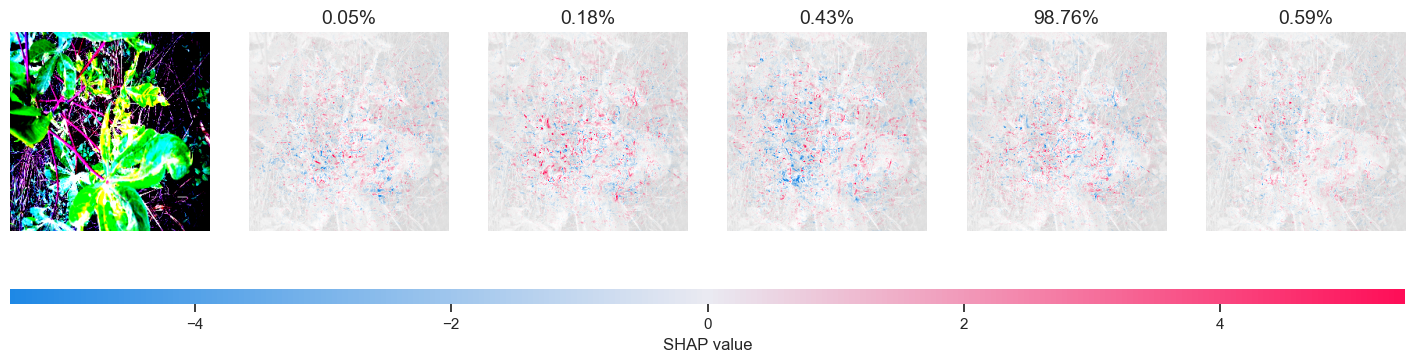

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


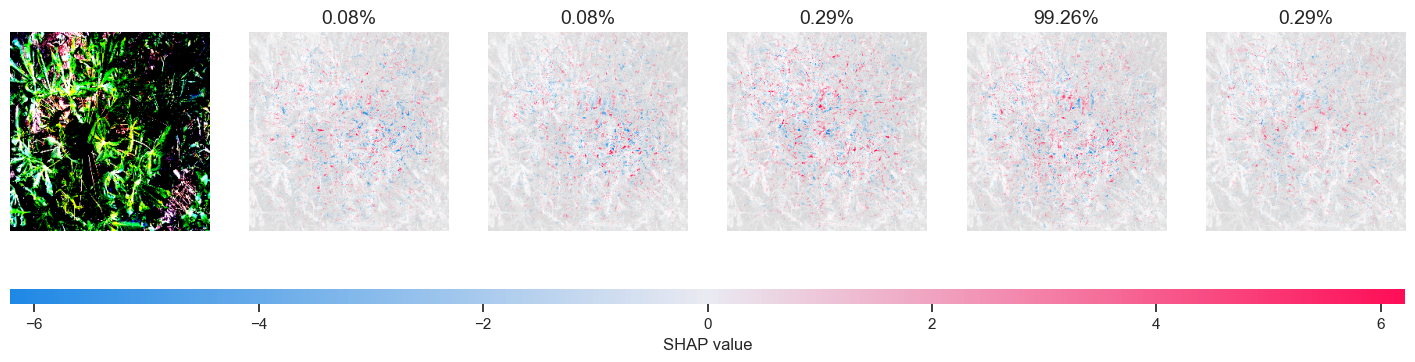

In [17]:
import matplotlib.pyplot as plt
show_attributions(model,test_images)

In [18]:
#Lime from https://notebook.community/marcotcr/lime/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch
    
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [19]:
def batch_predict(images):
    model.eval()
#     batch = torch.stack(tuple((i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to('cpu')
#     batch = batch.to(device)
    images = torch.tensor(images).permute(0,3,2,1)
    images = images.to("cpu")
    print(images.shape)
    logits = model(images)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [25]:
explanation = explainer.explain_instance(test_images[0].permute(2,1,0).cpu().numpy(), batch_predict,  
                                         top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


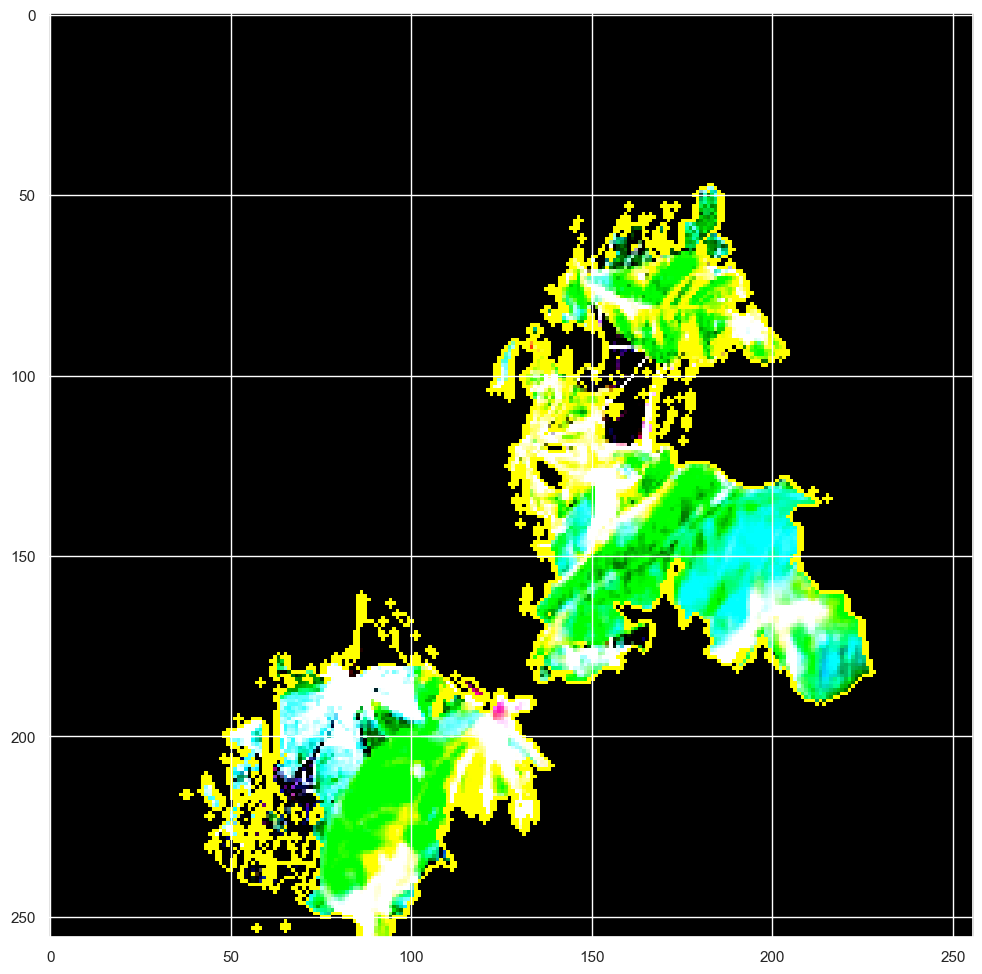

In [28]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp, mask)
plt.imshow(img_boundry1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


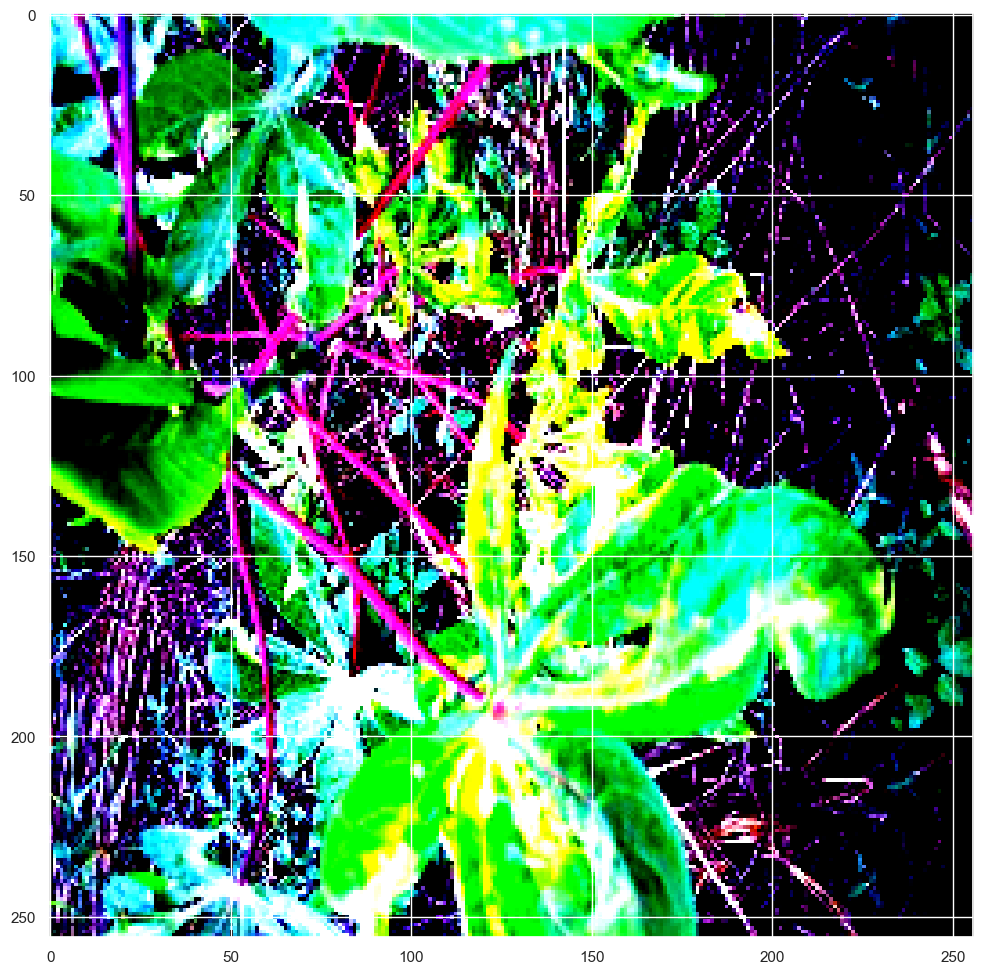

In [27]:
plt.imshow(test_images[0].permute(2,1,0))
